# Sequence to Sequence Model.
___
In this Notebook we will try to build a Seq to Seq Model for Machine Translations

## High-level steps for implementation of NMT involves.
___
1. Reading the data from the file containing the source and target sentences
2. Cleaning the data by converting to lowercase, removing spaces, special characters, digits, and quotes
3. Tag the start and end of the target sentence using START_ and _END respectively for training and inference
4. Create the dictionary of unique source and target words to vector and vice-versa
5. Shuffle the data for better generalization
6. Split the dataset into train and test data
7. Create the data; we will be using fit_generator() to fit the data to the model
8. Build the encoder using Embedding and LSTM layers
9. Build the decoder using Embedding and LSTM layers and takes input from the embedding layer and the encoder states.
10. Compile the model and train the model
11. Make predictions from the model

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

In [2]:
!!curl -O http://www.manythings.org/anki/npi-eng.zip
!!unzip  npi-eng.zip

['Archive:  npi-eng.zip',
 '  inflating: npi.txt                 ',
 '  inflating: _about.txt              ']

In [3]:
# Path to the data txt file on disk.
data_path = "/content/npi.txt"
# open the file eng-spa.txt and read
lines= pd.read_table(data_path,  names =['source', 'target', 'comments'])
#printing sample data from lines
lines.sample(6)

,source,target,comments
2466,Tom wanted to know who Mary was talking to.,टम जान्न चाहन्थे मेरी कोसंग कुरा गर्दै थिहिन्।,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
2102,Tom's coffee mug is next to Mary's.,टमको कफी मग मेरीको छेउमा छ।,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2677,Do you have any idea how much money you spent ...,तपाईंले गत वर्ष कपडामा कति पैसा खर्च गर्नुभयो ...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
126,I went there.,म त्यहाँ गएँ।,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
284,I want a friend.,मलाई एउटा साथी चाहियो।,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1345,Can you guess what this is?,के तपाई अनुमान गर्न सक्नुहुन्छ यो के हो?,CC-BY 2.0 (France) Attribution: tatoeba.org #3...


## Data Cleaning.

In [4]:
# convert source and target text to Lowercase
lines.source=lines.source.apply(lambda x: x.lower())
lines.target=lines.target.apply(lambda x: x.lower())
# Remove quotes from source and target text
lines.source=lines.source.apply(lambda x: re.sub("'", '', x))
lines.target=lines.target.apply(lambda x: re.sub("'", '', x))
# create a set of all special characters
special_characters= set(string.punctuation)
# Remove all the special characters
lines.source = lines.source.apply(lambda x: ''.join(char1 for char1 in x if char1 not in special_characters))
lines.target = lines.target.apply(lambda x: ''.join(char1 for char1 in x if char1 not in special_characters))
# Remove digits from source and target sentences
num_digits= str.maketrans('','', digits)
lines.source=lines.source.apply(lambda x: x.translate(num_digits))
lines.target= lines.target.apply(lambda x: x.translate(num_digits))
# Remove extra spaces
lines.source=lines.source.apply(lambda x: x.strip())
lines.target=lines.target.apply(lambda x: x.strip())
lines.source=lines.source.apply(lambda x: re.sub(" +", " ", x))
lines.target=lines.target.apply(lambda x: re.sub(" +", " ", x))

## ADD "sos" and "eos" TAG:

SOS: Start of Sentence.

EOS: ENd of Sentence.


In [5]:
# Add start and end tokens to target sequences
lines.target = lines.target.apply(lambda x : 'START_ '+ x + ' _END')
lines.sample(6)

,source,target,comments
2305,im from australia where are you from,START_ म अस्ट्रेलिया बाट हुँ। तपाईं कहाँबाट हु...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
149,he seems kind,START_ उहाँ दयालु देखिनुहुन्छ। _END,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
1459,i dont know where you live,START_ मलाई थाहा छैन तिमी कहाँ बस्छेउ। _END,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
743,its made of leather,START_ यो छालाबाट बनेको हो। _END,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
2616,what are some of the health benefits of eating...,START_ माछा खाँदा स्वास्थ्यमा हुने केही फाइदाह...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
948,tom makes model planes,START_ टमले नमुना विमानहरू बनाउँछ। _END,CC-BY 2.0 (France) Attribution: tatoeba.org #7...


## Create a Vocabulary.

We put all the words from source[English] to a list called source vocabulary.

We put all the words from target[French] to a list called target vocabulary.

In [6]:
# Find all the source and target words and sort them
# Vocabulary of Source language
all_source_words=set()
for source in lines.source:
    for word in source.split():
        if word not in all_source_words:
            all_source_words.add(word)
# Vocabulary of Target
all_target_words=set()
for target in lines.target:
    for word in target.split():
        if word not in all_target_words:
            all_target_words.add(word)
# sort all unique source and target words
source_words= sorted(list(all_source_words))
target_words=sorted(list(all_target_words))

## Finding longest sentence both in Source and Target.

In [7]:
#Find maximum sentence length in  the source and target data
source_length_list=[]
for l in lines.source:
    source_length_list.append(len(l.split(' ')))
max_source_length= max(source_length_list)
print(" Max length of the source sentence",max_source_length)
target_length_list=[]
for l in lines.target:
    target_length_list.append(len(l.split(' ')))
max_target_length= max(target_length_list)
print(" Max length of the target sentence",max_target_length)

 Max length of the source sentence 25
 Max length of the target sentence 22


## Creating a Look Up table.

We create a dicitionary word2indx both for source and target.

We will also Creata reverse dicitionary indx2word for both source and target.

In [8]:
# creating a word to index(word2idx) for source and target
source_word2idx= dict([(word, i+1) for i,word in enumerate(source_words)])
target_word2idx=dict([(word, i+1) for i, word in enumerate(target_words)])

In [9]:
#creating a dictionary for index to word for source and target vocabulary
source_idx2word= dict([(i, word) for word, i in  source_word2idx.items()])
print(source_idx2word)
target_idx2word =dict([(i, word) for word, i in target_word2idx.items()])

{1: 'a', 2: 'able', 3: 'aboard', 4: 'about', 5: 'above', 6: 'abroad', 7: 'abused', 8: 'accept', 9: 'accepted', 10: 'accident', 11: 'accountant', 12: 'accurate', 13: 'accurately', 14: 'across', 15: 'act', 16: 'active', 17: 'actor', 18: 'actually', 19: 'add', 20: 'addict', 21: 'address', 22: 'admit', 23: 'admitted', 24: 'advance', 25: 'adventures', 26: 'advice', 27: 'afraid', 28: 'after', 29: 'afternoon', 30: 'again', 31: 'age', 32: 'aggressive', 33: 'ago', 34: 'agree', 35: 'agreed', 36: 'ahead', 37: 'airport', 38: 'alcohol', 39: 'alice', 40: 'all', 41: 'allergic', 42: 'allergies', 43: 'allowed', 44: 'almost', 45: 'alone', 46: 'along', 47: 'already', 48: 'also', 49: 'alternative', 50: 'always', 51: 'am', 52: 'amazing', 53: 'ambitious', 54: 'amusing', 55: 'an', 56: 'ancient', 57: 'and', 58: 'angry', 59: 'animal', 60: 'animals', 61: 'announced', 62: 'annoying', 63: 'another', 64: 'answer', 65: 'answered', 66: 'any', 67: 'anybody', 68: 'anymore', 69: 'anyone', 70: 'anything', 71: 'anyway', 

In [14]:
#Shuffle the data
lines = shuffle(lines)

In [13]:
# Train - Test Split
X, y = lines.source, lines.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((2420,), (269,))

In [ ]:
# Input tokens for encoder
num_encoder_tokens=len(source_words)
# Input tokens for decoder zero padded
num_decoder_tokens=len(target_words) +1

### Generate in Batch:

To manage our memory we will create and input data pipeline in batches.


In [15]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
      for j in range(0, len(X), batch_size):
        encoder_input_data = np.zeros((batch_size, max_source_length),dtype='float32')
        decoder_input_data = np.zeros((batch_size, max_target_length),dtype='float32')
        decoder_target_data = np.zeros((batch_size, max_target_length, num_decoder_tokens),dtype='float32')
        for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
          for t, word in enumerate(input_text.split()):
            encoder_input_data[i, t] = source_word2idx[word]
            for t, word in enumerate(target_text.split()):
              if t<len(target_text.split())-1:
                decoder_input_data[i, t] = target_word2idx[word] # decoder input seq
                if t>0:
                   # decoder target sequence (one hot encoded)
                   # does not include the START_ token
                   # Offset by one timestep
                   #print(word)
                   decoder_target_data[i, t - 1, target_word2idx[word]] = 1.

            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [16]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 5
latent_dim=256

## Create a Model:
1. encoder inputs: The 2D array will be of shape (batch_size, max source sentence length). For a batch_size of 128 and a max source sentence length of 47, the shape of encoder_input will be (128,47)

2. decoder inputs: The 2D array will be of shape (batch_size, max target sentence length). For a batch_size of 128 and a max target sentence length of 55, the shape of decoder inputs will be (128,55)

3. decoder outputs: The 3D array will be of shape (batch_size, max target sentence length, number of unique words in target sentences). For a batch_size of 128 and a max target sentence length of 55, the shape of decoder output will be (128,55, 27200).

## Encoder Architecture.


Encoder encodes the input sentence.
1. It takes the input source tokens from input layer.
2. Embedding layer then translates sparse vectors into a dense lower dimesional space preserving teh semantic realtionships.
3. Create the LSTM layer and only set return_state to True, because we want hidden state and cell state, as an input to decoder.


In [17]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]


## Decoder Architecture.
Decoder uses hidden state and cell state from encoder and from embedding layer as an input.

Decoder returns output sentence and also hidden and cell states.

The final layer in decoder is linear layer(dense) with softmax activation function used for predictions.



In [18]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [19]:
# Define the model that takes encoder and decoder input
# to output decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [20]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [21]:
train_samples = len(X_train) # Total Training samples
val_samples = len(X_test)    # Total validation or test samples
batch_size = 128
epochs = 5

In [25]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

AttributeError: 'Functional' object has no attribute 'fit_generator'

In [ ]:
model.save_weights("nmt_weights_100epochs.h5")

## Make Inferences:

Steps in Inferences:

1. Encode the input sequences into hidden state and cell state of the LSTM
2. The decoder will predict one sequence at a time. The first input to the decoder will be hidden state and cell state of the encoder and the START_ tag
3. The output of the decoder will be fed as an input to the decoder for the next time step as shown in the diagram below.
4. At each time step, decoder outputs one-hot encoded vector to which we apply np.argmax and convert the vector to word from the dictionary that stores index to word
5. Keep appending the target words generated at each time step
Repeat the steps till we hit the _END tag or the word limit


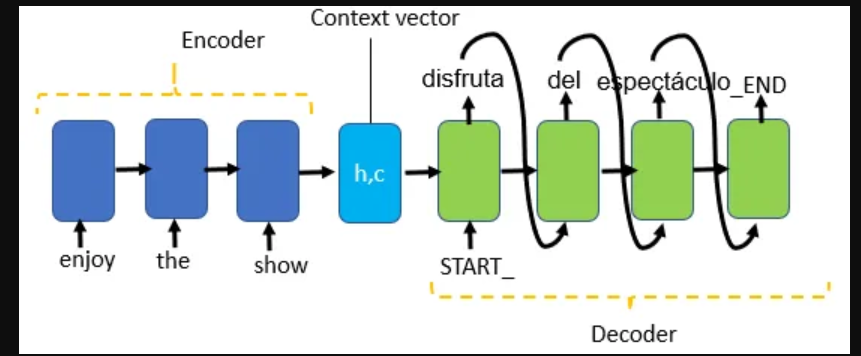

In [ ]:
# Encode the input sequence to get the "Context vectors"
encoder_model = Model(encoder_inputs, encoder_states)
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_input)
decoder_states2 = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)
# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_state_input,
    [decoder_outputs2] + decoder_states2)

### Function for Predictions:


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of
    #target sequence with the start character.
    target_seq[0, 0] = target_word2idx['START_']
# Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
# Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word =target_idx2word[sampled_token_index]
        decoded_sentence += ' '+ sampled_word
# Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True
# Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
# Update states
        states_value = [h, c]
    return decoded_sentence

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Source sentence:', X_train[k:k+1].values[0])
print('Actual Target Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Target Translation:', decoded_sentence[:-4])